In [1]:
####### All Imports #######
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import torch
from torch.utils import data
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
####### Setup Environment #######

# enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# (tf v2) - allowing GPU memory growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

#keras saving/loading issue attempt?
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# manual_variable_initialization(True)

1 Physical GPUs, 1 Logical GPUs


In [3]:
####### Configs for Machine Learning #######

### Loading Test/Training Data ###
load_urbansound_data = False # <-- Note: Urbansound8k has a shortcut for testing/debugging, only loads 1 folder (800 instead of 8000)
# Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
load_birds_data      = False
# Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
load_kaggle_data     = True
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
load_kaggle_cats_dogs_data  = False
# Data Source:  https://www.kaggle.com/mmoreaux/audio-cats-and-dogs
load_audioset_data   = False
# Data Source: https://research.google.com/audioset/index.html
# See scripts/README.md for downloading & filtering instructions.


### Loading/Saving Model ###
save_numpy = False # False = do nothing. String = Saves only features/labels into a .npy file within /data directory
load_numpy = False # False = load direct from wav files (SLOW). String = load features/labels from a .npy file
# save_numpy = "kaggle50.npy" # all_data_<name.npy> and all_labels_<name.npy>
load_numpy = "kaggle50.npy" # all_data_<name.npy> and all_labels_<name.npy>

load_model_file = False # False = create new model, String = load pre-trian model from filename (no filename extension).
save_model_file = False # False = do nothing, String = save trained model to filename (no filename extension).
# save_model_file = "urbansound_first_try" 
# load_model_file = "urbansound_first_try"


### Training / Fitting / Optimizing Model #####
test_size = 0.2
epochs    = 60
batch_size= 50
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

do_model_analysis = False

In [4]:
####### HELPER FUNCTIONS (Table of Content) #######
# extract_features()
# display_wav()
# load_all_wav_files()
#    load_urbansound
#    load_birds
#    load_kaggle
#    load_kaggle_cats_dogs
#    load_audioset_data
# analyze_features()
# plot_history() loss & accuracy v epochs)
# plot_confusion_matrix()

In [5]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    features = []
    
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52
    
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features.extend(contrast) # 7 = 187

# More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [6]:
def display_wav(file = None):
    # Displays comparison of loading a wav file via librosa vs via scipy
    if not file:
        print("No wav file to display")
        return
    librosa_load, librosa_sampling_rate = librosa.load(file)
    scipy_sampling_rate, scipy_load = wavfile.read(file)
    print('original sample rate:',scipy_sampling_rate)
    print('converted sample rate:',librosa_sampling_rate)
    print('\n')
    print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
    print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_load)
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_load)

In [7]:
def load_all_wav_files(load_urbansound=False,
                       load_birds=False,
                       load_kaggle=False,
                       load_kaggle_cats_dogs=False,
                       load_audioset=False):
    '''
    Returns two numpy array
    The first is a numpy array containing each audio's numerical features - see extract_features()
    The second numpy array is the array *STRING* of the label.
    (The array indexes align up between the two arrays. data[idx] is classified as labels[idx]) 
    '''
    one_file = None
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
    #UltraSound8K
    if load_urbansound:
        print("loading Ultrasound8k")
        # Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
        metadata = pd.read_csv("./data/UrbanSound8K/metadata/UrbanSound8K.csv")
        for root, dirs, files in os.walk("./data/UrbanSound8K"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
#SHORTCUT
# This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
#             if len(all_data) > 0: 
#                 break
#END SHORTCUT
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    label = metadata[metadata.slice_file_name == file]["class"].tolist()[0]
#                     if(label == "dog_bark"):
                    all_data.append(features)
                    all_labels.append(label)
                    one_file = fname
#                     display_wav(fname)
#                     break


    if load_birds:
        print("Loading birds")
        # Data Source: http://dcase.community/challenge2018/task-bird-audio-detection
        # Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append("chirping_birds")


    if load_kaggle:
        print("Loading Kaggle")
        # Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
        metadata = pd.read_csv("./data/environmental-sound-classification-50/esc50.csv")
        for root, dirs, files in os.walk("./data/environmental-sound-classification-50/"):
            for file in files:
        #for file in os.listdir("./data/environmental-sound-classification-50/audio"):
        #    fname = "./data/environmental-sound-classification-50/audio/"+file
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    label = metadata[metadata.filename == file]["category"].tolist()[0]
                    animals=["cat", "chirping_birds","cow","crickets","crow","dog","frog","hen","insects","pig","rooster","sheep"]
                    if label in animals:
                        if(len(all_data) % 100 == 0):
                            print(str(len(all_data)))
                        features = extract_features(fname)
                        all_data.append(features)
                        all_labels.append(label)

    if load_kaggle_cats_dogs:
        print("Loading Kaggle cats and dogs")
        # Data Source:  https://www.kaggle.com/mmoreaux/audio-cats-and-dogs
        metadata = pd.read_csv("./data/kaggle_cats_dogs/train_test_split.csv")
        for file in os.listdir("./data/kaggle_cats_dogs/cats_dogs"):
            fname = "./data/kaggle_cats_dogs/cats_dogs/"+file
            if file.endswith('.wav'):
                if(len(all_data) % 100 == 0):
                    print(str(len(all_data)))
                features = extract_features(fname)
                all_data.append(features)
                label = 'cat' if file.startswith('cat') else 'dog'
                all_labels.append(label)
#                 one
     
    if load_audioset:
        err_files = []
        # Data Source: https://research.google.com/audioset/index.html
        # See scripts/README.md for downloading & filtering instructions.
        print("Loading Audioset")
        metadata_b = pd.read_csv("./data/audioset/balanced_train_segments-animals.csv")
        metadata_e = pd.read_csv("./data/audioset/eval_segments-animals.csv")
        metadata_l = pd.read_csv("./data/audioset/class_labels_indices-animals.csv")
#         print("METADATA BALANCED", metadata_b.head())
#         print("METADATA EVAL", metadata_e.head())
#         print("METADATA LABEL", metadata_l.head())
        for root, dirs, files in os.walk("./data/audioset"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    try:
                        features = extract_features(fname)
                    except ValueError as err:
                        # Errors out on files that are empty or nearly empty
                        err_files.append(fname)
                        continue
#                     file_id = file.replace(".wav", "")
                    fid = re.sub(r'_[\d\.]+wav$','',file)
                    temp = None
                    if "balanced_train_segments" in fname:
#                         temp = metadata_b[metadata_b['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                        temp = metadata_b[metadata_b['# YTID'] == fid]["Unnamed: 3"].tolist()
                    elif "eval_segments" in fname:
#                         temp = metadata_e[metadata_e['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                        temp = metadata_e[metadata_e['# YTID'] == fid]["Unnamed: 3"].tolist()
                    if not temp:
                        continue
                    label_code = temp[0]
                    label_temp = metadata_l[metadata_l.mid == label_code]["display_name"].to_list()
                    if not label_temp:
                        continue
                    label = label_temp[0]
                    
                    all_data.append(features)
                    all_labels.append(label)
                    if(len(all_data) >= 1000):
                        break
        if err_files:
            print("{} ERROR FILES:\n {}".format(len(err_files), err_files))
        
    
    return np.array(all_data), np.array(all_labels), one_file

In [8]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)
#     print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
#     print(corr['SalePrice'].sort_values(ascending = False)[-5:])

In [9]:
def plot_history(history = None):
    # Plots accuracy & loss versus epochs
    if not history:
        print("No history to plot")
        return
    fig = plt.figure(figsize=(10,8))
#     fig = plt.figure(figsize=(20,16))
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.axis([0,90,0,1.1])
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

In [10]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

In [11]:
all_data = np.array([])
all_labels = np.array([])
one_file = None
if not load_numpy:
    all_data, all_labels, one_file = load_all_wav_files(load_urbansound_data,
                                          load_birds_data,
                                          load_kaggle_data,
                                          load_kaggle_cats_dogs_data,
                                          load_audioset_data)
else:
    all_data = np.load("data/all_data_"+load_numpy)
    all_labels = np.load("data/all_labels_"+load_numpy)
if save_numpy:
    np.save("data/all_data_"+save_numpy, all_data)
    np.save("data/all_labels_"+save_numpy, all_labels)
# # display_wav(one_file)

In [12]:
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)

(1440, 187)
['sheep', 'cow', 'hen', 'pig', 'chirping_birds', 'crow', 'frog', 'dog', 'cat', 'insects', 'rooster', 'crickets']


In [13]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=test_size, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1152, 187)
(1152,)
(288, 187)
(288,)


In [14]:
model = Sequential()
model.add(Dense(256, activation='relu',  input_dim=x_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax')) # sigmoid

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
history = None
if load_model_file:
    fpath = os.path.join("model", load_model_file + ".hdf5")
    model.load_weights(fpath)
elif save_model_file:
    fpath = os.path.join("model", save_model_file + ".hdf5")
    checkpointer = ModelCheckpoint(filepath=fpath,
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   verbose=1)
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer],
#                         shuffle=True,
                        verbose=2)
else:
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
#                         shuffle=True,
                        verbose=2)

Train on 1152 samples, validate on 288 samples
Epoch 1/60
 - 0s - loss: 6.0807 - accuracy: 0.2422 - val_loss: 2.5890 - val_accuracy: 0.3819
Epoch 2/60
 - 0s - loss: 1.6495 - accuracy: 0.5200 - val_loss: 1.3408 - val_accuracy: 0.5660
Epoch 3/60
 - 0s - loss: 1.0641 - accuracy: 0.6589 - val_loss: 0.9800 - val_accuracy: 0.6493
Epoch 4/60
 - 0s - loss: 0.9916 - accuracy: 0.6832 - val_loss: 0.8646 - val_accuracy: 0.7049
Epoch 5/60
 - 0s - loss: 0.7685 - accuracy: 0.7422 - val_loss: 0.7927 - val_accuracy: 0.7257
Epoch 6/60
 - 0s - loss: 0.7405 - accuracy: 0.7517 - val_loss: 0.7920 - val_accuracy: 0.7292
Epoch 7/60
 - 0s - loss: 0.7299 - accuracy: 0.7726 - val_loss: 0.5511 - val_accuracy: 0.8021
Epoch 8/60
 - 0s - loss: 0.4856 - accuracy: 0.8429 - val_loss: 0.5487 - val_accuracy: 0.8194
Epoch 9/60
 - 0s - loss: 0.3967 - accuracy: 0.8733 - val_loss: 0.5769 - val_accuracy: 0.8264
Epoch 10/60
 - 0s - loss: 0.6350 - accuracy: 0.8134 - val_loss: 0.5235 - val_accuracy: 0.8333
Epoch 11/60
 - 0s - lo

In [16]:
# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               48128     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total params: 90,060
Trainable params: 90,060
Non-trainable params: 0
_________________________________________________________________


In [17]:
score_train = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_train[1])
print("Training Cross Entropy: %.2f" % score_train[0])

score_test = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

Training Accuracy:  1.0
Training Cross Entropy: 0.01
Testing Accuracy:  0.9722222089767456
Testing Cross Entropy: 0.13


In [18]:
y_pred_percentages = model.predict(x_test) # predicted percentages

y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction

cm = confusion_matrix(y_test, y_pred)

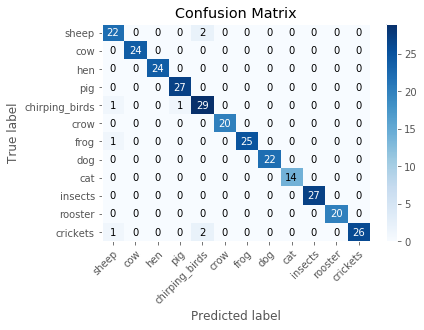

In [19]:
plot_confusion_matrix(cm)

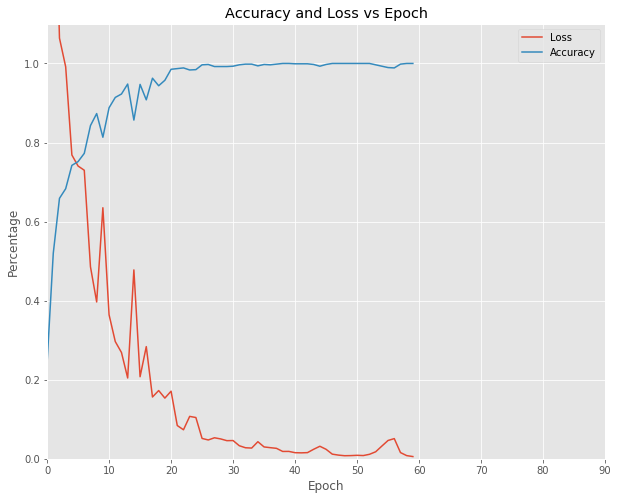

In [20]:
plot_history(history)

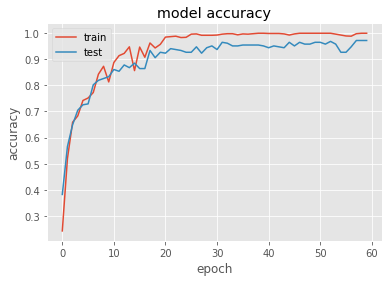

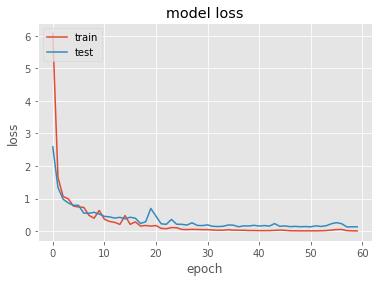

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#32, 32 lstm, w/ mel, chroma, zcr, mfcc, sp_centroid, sp_rolloff
#sgd 0.01
#***

In [22]:
# def model_analysis()
#     lr = [ 10**lr_power for lr_power in range(0, -6,-1)]
#     epochs = [10**e_power for e_power in range(1)]
        